In [2]:
import numpy as np
import os
import pathlib
import sys

from joblib import load

if pathlib.Path(os.getcwd()).parents[2] not in sys.path:
    sys.path.append(str(pathlib.Path(os.getcwd()).parents[2]))

from Sensors.BatEcho.Spatializer import Render
from Sensors.BatEcho import Setting as sensorconfig
from Gym.BeaconDocking_v0 import Helper
from Arena import Builder

from Control.SensorimotorLoops.BatEcho import AvoidApproach, Avoid
from Simulation.Motion import State
from Control.SensorimotorLoops import Setting as controlconfig

from matplotlib import pyplot as plt
%matplotlib inline

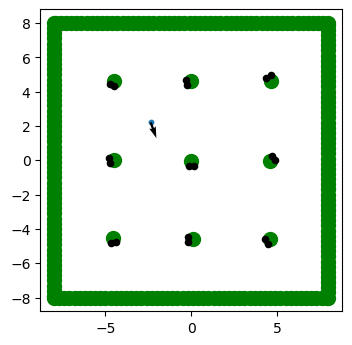

In [3]:
obstacles = Helper.box_builder('')
bat_pose, beacons = Helper.initializer(jit=1)
# merge obstacles and beacons into an objects array
objects = Helper.concatenate_beacons(beacon_objs=Helper.beacons2objects(beacons), 
                                     objects=obstacles)

fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.scatter(bat_pose[0], bat_pose[1], s=10)
ax.quiver(bat_pose[0], bat_pose[1], np.cos(bat_pose[2]), np.sin(bat_pose[2]))

ax.set_aspect('equal')

In [8]:
dockingZone_cls = load('dockingZone_classifier.joblib')

In [11]:
dockingZone_cls.predict(np.asarray([5, 0, np.pi]).reshape(1,3))

array([0.])

In [126]:
cache = []

In [177]:
def avoid_overwite(pose, maze_size=Helper.MAZE_SIZE, margin = 2):
    x, y = pose[:2]
    t = 0.5*maze_size - margin
    if (np.abs(x) > t) or (np.abs(y) > t): return True
    return False

def sort_beacons_by_distance(pose, beacons):
    x_sq = np.power(beacons[:,0] - pose[0],2)
    y_sq = np.power(beacons[:,1] - pose[1],2)
    distance_squared = x_sq + y_sq
    sorted_beacons = beacons[np.argsort(distance_squared)]
    return sorted_beacons, np.sqrt(distance_squared)

def beacon_centric_pose_converter(pose, beacon):
    p = np.copy(pose).reshape(1,3)
    # translate -> beacons center and zero zero.
    p[:,:2] = p[:,:2] - beacon[:2].reshape(-1,2)
    # rotate -> beacon direction yaw = 0
    theta = -beacon[2]
    rotmat = np.asarray([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)], dtype=np.float32).reshape(2,2)
    p[:,:2] = np.matmul(rotmat, p[:,:2].T).T
    p[:,2] = Builder.wrap2pi(p[:,2] + theta)
    return p

def behavior(pose, beacons, avoid_overwrite_func, sort_beacons_by_distance_func, beacon_centric_pose_convert_func, cls, random_approach_threshold=0.8):
    if avoid_overwrite_func(pose):
        return 0.
    sorted_beacons, sorted_distances = sort_beacons_by_distance_func(pose, beacons)
    for beacon, dist in zip(sorted_beacons, sorted_distances):
        if dist > 8: continue
        beacon_centric_pose = beacon_centric_pose_convert_func(pose, beacon)
        dockingZone_indicator = cls.predict(beacon_centric_pose.reshape(1,3))[0]
        if dockingZone_indicator == 0: 
            cache.append(beacon_centric_pose)
            return 1.
        if dockingZone_indicator == 1: return 0.
    if np.random.rand() < random_approach_threshold: return 1.
    else: return 0.

In [178]:
def run_episode(init_pose, beacons, objects, time_limit=10_000):
    pose = np.copy(init_pose)
    render = Render()
    state = State(pose=pose, dt=1/controlconfig.CHIRP_RATE)
    controller = AvoidApproach()
    poses = np.copy(pose).reshape(1,3)
    actions = []
    for _ in range(time_limit):
        compressed = render.run(pose, objects)
        docked = Helper.dockingCheck(pose, beacons)
        if docked:
            print('DOCKED')
            return poses, np.asarray(actions), 'docked'
        if Helper.collision_check(render.cache['inview'], 'plant'):
            print('HIT PLANT')
            return poses, np.asarray(actions), 'hit_plant'
        if Helper.collision_check(render.cache['inview'], 'pole'):
            print('HIT POLE')
            return poses, np.asarray(actions), 'hit_pole'
        action = behavior(pose, beacons,
                          avoid_overwrite_func=avoid_overwite,
                          sort_beacons_by_distance_func=sort_beacons_by_distance,
                          beacon_centric_pose_convert_func=beacon_centric_pose_converter,
                          cls = dockingZone_cls)
        actions.append(action)
        v, omega = controller.get_kinematic(compressed, approach_factor=action)
        state.update_kinematic(kinematic=[v, omega])
        state.update_pose()
        pose = np.copy(state.pose)
        poses=np.vstack((poses, pose.reshape(1,3)))
        
    print('OUT')
    return poses, np.asarray(actions), 'out'

random_approach_threshold=0.2
margin = 2.5
--> 75% Docked
--> 18% Hit pole

In [179]:
results = []

for _ in range(20):
    bat_pose, beacons = Helper.initializer(jit=1)
    objects = Helper.concatenate_beacons(beacon_objs=Helper.beacons2objects(beacons), 
                                     objects=obstacles)
    poses_mat, act_mat, result = run_episode(init_pose=bat_pose, beacons=beacons, objects=objects)
    results.append(result)

HIT POLE
DOCKED
DOCKED
HIT PLANT
HIT PLANT
HIT POLE
DOCKED
HIT POLE
HIT PLANT
HIT PLANT
HIT POLE
DOCKED
DOCKED
HIT POLE
DOCKED
DOCKED
DOCKED
HIT PLANT
DOCKED
DOCKED


In [180]:
count = 0
for r in results:
    count +=1 if r=='docked' else 0
print(count)

10


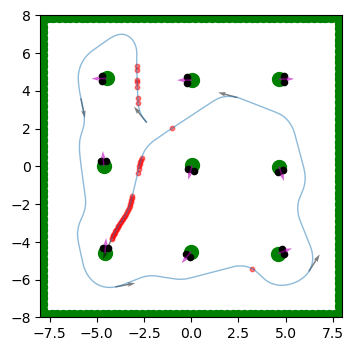

In [168]:
quiverspacing=100
fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.plot(poses_mat[:,0], poses_mat[:,1], linewidth=1, alpha=0.5)
ax.scatter(poses_mat[np.where(act_mat==1)][:,0],poses_mat[np.where(act_mat==1)][:,1], c='r', s=10, alpha=0.5)

ax.quiver(poses_mat[::quiverspacing,0], poses_mat[::quiverspacing,1], np.cos(poses_mat[::quiverspacing,2]), np.sin(poses_mat[::quiverspacing,2]), scale=15, width=5e-3, alpha=0.5)

ax.quiver(beacons[:,0], beacons[:,1], np.cos(beacons[:,2]), np.sin(beacons[:,2]), color='m', scale=20, width=5e-3, alpha=0.6)

ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_aspect('equal')

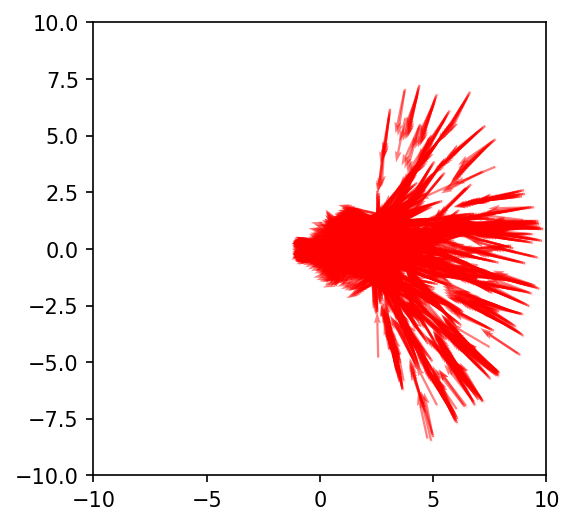

In [167]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(np.asarray(cache).reshape(-1,3)[:,0],np.asarray(cache).reshape(-1,3)[:,1], c='r', s=0.1, alpha=0.1)
ax.quiver(np.asarray(cache).reshape(-1,3)[:,0],np.asarray(cache).reshape(-1,3)[:,1], np.cos(np.asarray(cache).reshape(-1,3)[:,2]), np.sin(np.asarray(cache).reshape(-1,3)[:,2]),
          scale=10, width=5e-3, color='r', alpha=0.5)

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_aspect('equal')

In [131]:
cache

[]